# STA 130 Lab 7: The Bootstrap
*Your Name Here*

The Central Limit Theorem was key in formulating the specific confidence interval for the estimate of the mean of a population we talked about in class.  For instance,  because the CLT says that the sample mean is normally distributed ($\bar{X} \sim N(\mu, \frac{\sigma}{\sqrt{n}})$), we can use the standard normal table to get critical values for the confidence interval.  These critical values scale the standard error of $\bar{X}$
(or any point estimator) to cover the desired level of confidence (e.g.  95%).  What if we didn’t have the CLT to tell us where to get these critical values from?  The goal of this lab is to investigate how to use bootstrapping to estimate confidence intervals.

## Bootstrapping

The method of bootstrapping (or bootstrap sampling) allows us to estimate the confidence
interval for a population parameter when we only know the estimator (a function) and have
a sample.  That is, we don’t know where to get our critical value from.  Finding bootstrapped
confidence intervals generally goes like this:

1.  Determine the sample size $n$ based on the problem statement.
2.  Decide on a confidence level $(1-\alpha)$.
3.  Repeat $m$ times:
  1. Randomly draw a sample of size $n$ with replacement from your original sample (this is called a “bootstrap sample”).
  2. Calculate your point estimate of interest on this bootstrap sample.
4.  Look  at  the  distribution  of  your $m$ estimates  (the  “bootstrap  distribution”).   If  it is  roughly  symmetric,  you  may  proceed. (There  is  another  method  for  asymmetric distributions, but we won’t get into that here.)
5.  Order your $m$ bootstrap point estimates from lowest to highest.
6.  Your $100(\alpha/2)%$ lowest bootstrap estimate is your lower bound and your $100(1−\alpha/2)%$ lowest  estimate  is  your  upper  bound  on  your  confidence  interval.   Thus,  if  we  have 1,000 bootstrap samples and a 95% confidence interval,  our lower bound will be the 25th lowest estimate our upper bound will be the 975th lowest estimate (25th largest estimate).

## Why it works

Bootstrapping gives us a reliable estimate of the confidence interval for a population parameter because, with an unbiased estimator:
1.  Our sampling distribution is centered about our true population parameter value.
2.  Our bootstrap distribution is centered about our sample’s estimate of the true population value. 

Thus,  with  a  symmetric  bootstrap  distribution,  we  expect  our  bootstrap  distribution  to
have the same relationship to our one sample estimate as our sampling distribution (of the
estimator, if we could draw lots of real samples) would have to the true population value.

## Data
The RealEstate dataset (in excel and csv format) contains a collection of recent real estate listings in San Luis Obispo county.  The dataset contains the following fields:

- MLS: Multiple listing service number for the house (unique ID).
- Location:  city/town where the house is located. 
- Price:  the most recent listing price of the house (in dollars).
- Bedrooms:  number of bedrooms.
- Bathrooms:  number of bathrooms.
- Size:  size of the house in square feet.
- Price/SQ.ft:  price of the house per square foot.
- Status: type of sale.  Thee types are represented in the dataset: Short Sale, Foreclosure and Regular.

## Assignment
Focus on the `Price` variable. We are interested in the price of homes in the town of Paso Robles, which is just one of the towns included in this data set.  Return a *maximum* 2 page report to answer the following questions, providing both concise numeric summaries and commentary that is understandable for the average introductory statistics student. 

*Write your own function to perform the bootstrap, do not use any Python libraries that perform bootstrapping for you.* 

1. Draw a histogram and boxplot of the “Price” variable.  Comment on the distribution.

2. Obtain  a  point  estimate  and  a  95%  CI  of  the mean from  the  sample,  using  the central limit theorem for your chosen sample size $n$.

3. Find the standard error and 95% confidence interval of the estimate for mean of the  “Price”  variable  using  bootstrapping.   Try a few  different  numbers  of  iterations  for bootstrapping:  1000, 5000, 10000, and plot the obtained standard error against the number of iterations.  Compare the bootstrapped CIs with those theoretical CIs obtained using the CLT.

**Hint:** Are Wald intervals (symmetric confidence intervals) from this resampled distribution valid? How can you tell?

4. Median of the housing prices:  Can we still use CLT to find the 95% estimate of the median of the prices?  Find the median using a bootstrap procedure, then compare your bootstrapped value to the median of the original data.

In [126]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [127]:
real_df = pd.read_csv("./RealEstate.csv")

In [128]:
real_df.head()

,MLS,Location,Price,Bedrooms,Bathrooms,Size,Price/SQ.Ft,Status
0,132842,Arroyo Grande,795000.0,3,3,2371,335.30,Short Sale
1,134364,Paso Robles,399000.0,4,3,2818,141.59,Short Sale
2,135141,Paso Robles,545000.0,4,3,3032,179.75,Short Sale
3,135712,Morro Bay,909000.0,4,4,3540,256.78,Short Sale
4,136282,Santa Maria-Orcutt,109900.0,3,1,1249,87.99,Short Sale


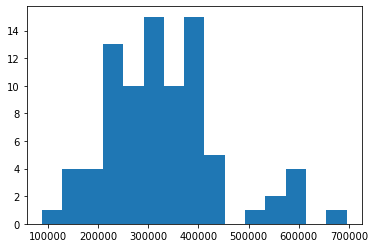

In [129]:
subpop = real_df[real_df.Location == "Paso Robles"]
plt.hist(subpop.Price, bins = 15)
pass

In [130]:
pd.DataFrame(subpop["Price"].describe())

,Price
count,85.000000
mean,334280.223529
std,113163.278283
min,89000.000000
25%,250000.000000
50%,319900.000000
75%,399000.000000
max,695000.000000


In [131]:
def bootstrap(data, var, n_sample, n_iter, conf):
    """
    This is a function to find boostrapped confidence intervals and 
    point estimates from a random sample.
    
    Inputs:
    data is a Pandas data frame object
    var is a string argument, this is the variable of interest
    n_sample is the sample size drawn with replacement at each iteration
    n_iter is an integer, the number of iterations of 
        resampling w/ replacement to perform
    conf is the confidence level (e.g. 0.95 for a 95% CI)
    
    Outputs:
    Bootstrapped estimates of the mean, median, SE, (1-conf)/2 %ile, (1+conf)/2 %ile
    An array of size n_iter of the elements of the resampled means
    """
    
    resampled = np.zeros((n_iter, 2)) # pre-allocate
    
    # perform resampling
    for i in range(n_iter):
        # sample with replacement from data frame, return only sample mean of var of interest
        sample = data.sample(n = n_sample, replace = True)[var]
        resampled[i,0] = np.mean(sample)
        resampled[i,1] = np.median(sample)
    
    # calculate summary stats based upon resampled values
    results = pd.DataFrame(
        data = np.array([
         np.mean(resampled[:,0]),
         np.std(resampled[:,0]),
         np.quantile(resampled[:,1], q = 0.5), # est of median, could also calc CI for median
         np.quantile(resampled[:,0], q = (1-conf)/2), # CI for mean - lower
         np.quantile(resampled[:,0], q = (1+conf)/2)  # CI for mean - upper
        ]),
        index = ["Mean", "SE", "Med", "Lower_95CI", "Upper_95CI"],
        columns = [var]
    )
    
    return (results.round(2), resampled)
    

In [132]:
np.random.seed(516) # set random seed for reproducibility
bs1 = bootstrap(subpop, "Price", subpop.shape[0], 1000, 0.95)

In [133]:
bs1[0]

,Price
Mean,333730.57
SE,12270.14
Med,319900.00
Lower_95CI,309851.99
Upper_95CI,357341.72


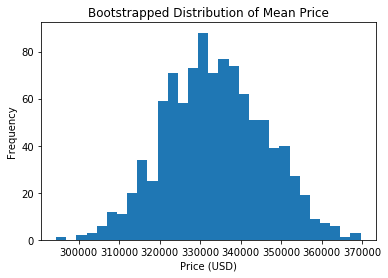

In [139]:
plt.hist(bs1[1][:,0], bins=30)
plt.title("Bootstrapped Distribution of Mean Price")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
pass

In [135]:
np.std(subpop["Price"])/np.sqrt(subpop.shape[0]) # theoretical SE from original sample

12201.865614669066

Grading:
- Students should include a summary table that includes bootstrapped estimates for each of the 3 varied n_iter inputs, as well as the theoretical values of each statistic under the CLT.
- Students should demonstrate that bootstrapped confidence intervals are valid here because the output is symmetric.
- Students should comment on the relationship between the theoretical and bootstrapped values, as well as any challenges to the validity of this procedure. 